In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

In [2]:
data, labels = make_classification(n_samples=1000,
                                   n_features=2, n_informative=2,
#                                    n_classes=2,
                                   n_redundant=0,
                                   n_clusters_per_class=1, random_state=13)

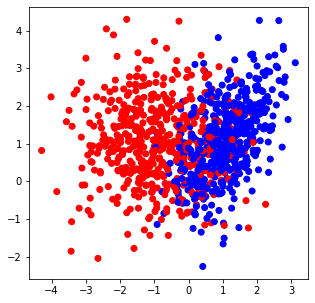

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(5,5))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=colors);
plt.show()

In [4]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
#         b_test = [data[i] for i in range(0, data.shape[0]) if i not in sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [7]:
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
def gain(left_labels, right_labels, root_criterion, criterion):

    # доля выборки, ушедшая в левое поддерево
    p = left_labels.shape[0] / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [9]:
def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [10]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 3

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
#     feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
#     Из двух признаков не имеет смысла делать подвыборку
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 3 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini, gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [11]:
def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [12]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [13]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [15]:
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [16]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                                    labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [17]:
def accuracy(y, y_pred):
    return round(np.mean(1-abs(y-y_pred)),3)

In [18]:
def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, my_forest):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={accuracy(train_labels,train_answers)}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={accuracy(test_labels,test_answers)}')

In [19]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

train_answers = tree_vote(my_forest_1, train_data)
test_answers = tree_vote(my_forest_1, test_data)

# print(accuracy(train_labels,train_answers), accuracy(test_labels,test_answers))

Wall time: 329 ms


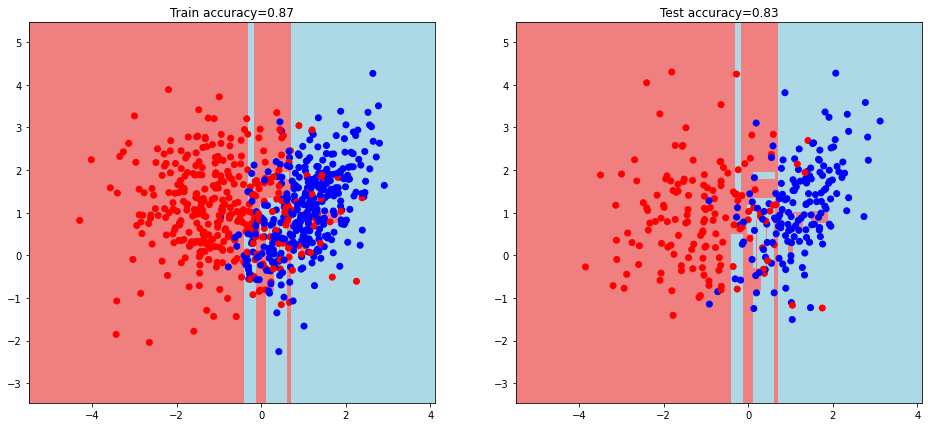

In [20]:
visualize(train_data, test_data, my_forest_1)

Wall time: 4.96 s


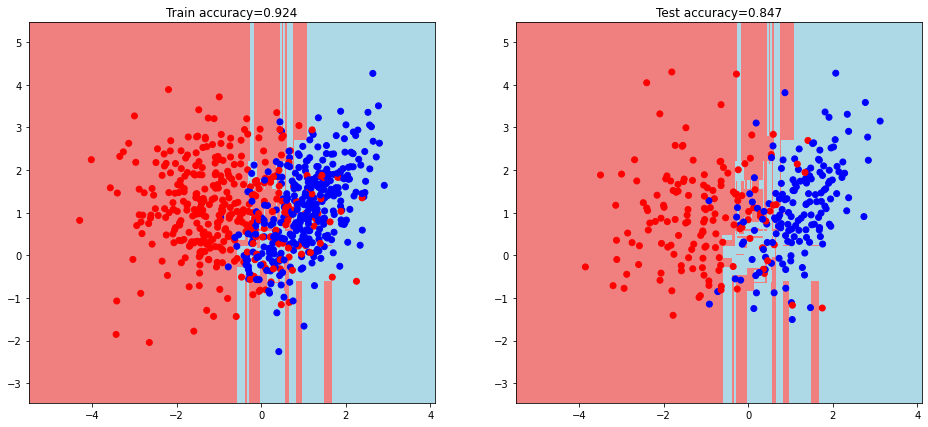

In [21]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

train_answers = tree_vote(my_forest_3, train_data)
test_answers = tree_vote(my_forest_3, test_data)

# print(accuracy(train_labels,train_answers), accuracy(test_labels,test_answers))
visualize(train_data, test_data, my_forest_3)

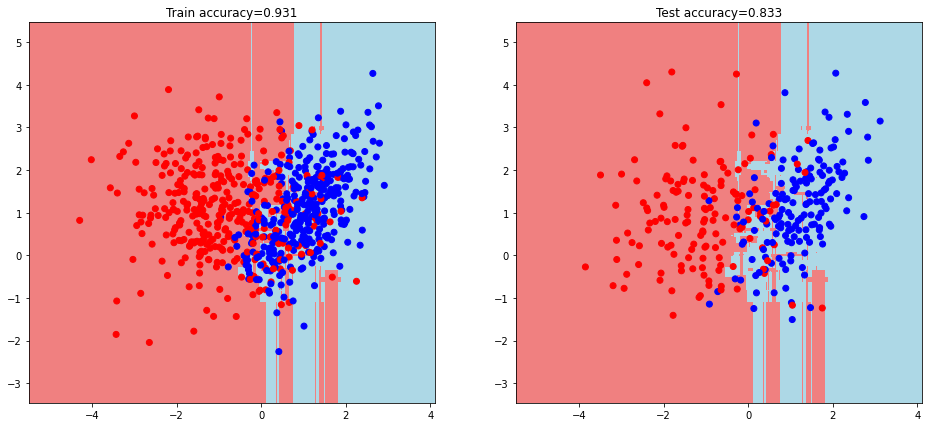

In [22]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

train_answers = tree_vote(my_forest_10, train_data)
test_answers = tree_vote(my_forest_10, test_data)

# print(accuracy(train_labels,train_answers), accuracy(test_labels,test_answers))
visualize(train_data, test_data, my_forest_10)

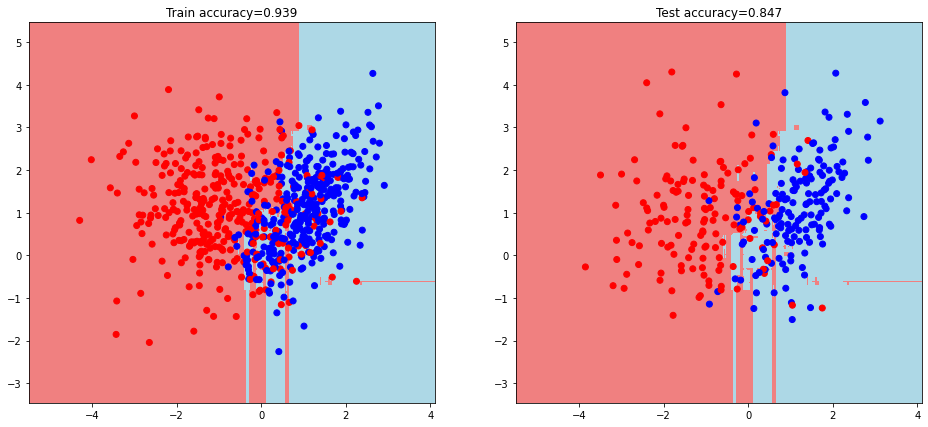

In [23]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

train_answers = tree_vote(my_forest_50, train_data)
test_answers = tree_vote(my_forest_50, test_data)

# print(accuracy(train_labels,train_answers), accuracy(test_labels,test_answers))
visualize(train_data, test_data, my_forest_50)

На 10 деревьях уже похоже на переобучение

Для реализации проверки с помощью отложенной выборки переписываю следующие функции:

In [24]:
np.random.seed(42)

def get_bootstrap_OOB(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
#         b_data = data[sample_index]
#         b_labels = labels[sample_index]
#         bootstrap.append((b_data, b_labels))
#         b_test = [data[i] for i in range(0, data.shape[0]) if i not in sample_index]
        test_index = [i for i in range(n_samples) if i not in sample_index]
        bootstrap.append((sample_index, test_index))
        
    return list(zip(*bootstrap))

In [25]:
def tree_vote_OOB(predictions):
  
    predictions_per_object = list(zip(*predictions))
    voted_predictions = []
    
    for obj in predictions_per_object:
        pred = {}
        for el in obj:
            if el not in pred:
                pred[int(el)] = 0
            pred[int(el)] +=1 
        
        if -1 in pred:
            pred.pop(-1)
            
        if pred:
            voted_predictions.append(max(pred))
        else:
            voted_predictions.append(None)              
        
    return voted_predictions

In [26]:
def random_forest_OOB(data, labels, n_trees):

    sample_index, test_index = get_bootstrap_OOB(data, labels, n_trees)
    
#   Создаю массивы, куда бузу записывать предсказанные значения так,
# чтобы индекс объекта и предсказания на объекте были одинаковыми.
# Если предсказания для данного признака нет,  эдемент массива останется со значением -1
    train_predictions = -np.ones((n_trees, data.shape[0]))
    test_predictions = -np.ones((n_trees, data.shape[0]))
    predictions = []
  
    for i in range(n_trees):
        
        tree = build_tree(data[sample_index[i]], labels[sample_index[i]])
        predictions = predict(data, tree)
#         В зависимости от того попал, ли объект в выборку для обучения или нет, записываю предсказания на нем в 
#        массив предсказаний для выборки обучения либо тестовой
        for j in range(data.shape[0]):
            if j in test_index[i]:
                test_predictions[i][j] = predictions[j]
            else:
                train_predictions[i][j] = predictions[j]
        
    train_voted_predictions = tree_vote_OOB(train_predictions)
    test_voted_predictions = tree_vote_OOB(test_predictions)    
        
    return train_voted_predictions, test_voted_predictions

In [27]:
train_pred, test_pred = random_forest_OOB(data, labels, 10)

In [28]:
train_pred = np.array(train_pred)
train_pred_filled = train_pred[train_pred != None]
labels_ = labels[train_pred != None]

accuracy(train_pred_filled, labels_)

0.896

In [29]:
test_pred = np.array(test_pred)
test_pred_filled = test_pred[test_pred != None]
labels_ = labels[test_pred != None]

accuracy(test_pred_filled, labels_)

0.823